<a href="https://colab.research.google.com/github/merazAfridi/Slum-vs-Non-Slum-Seg/blob/main/Slum_vs_Non_Slum_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/slum-train-test-updated/Only Slum Dataset/Trainset/images/Molla Bosti-11.jpg
/kaggle/input/slum-train-test-updated/Only Slum Dataset/Trainset/images/Vashantek11.jpg
/kaggle/input/slum-train-test-updated/Only Slum Dataset/Trainset/images/Narayangonj-Adaamjee-32.jpg
/kaggle/input/slum-train-test-updated/Only Slum Dataset/Trainset/images/Vashantek14.jpg
/kaggle/input/slum-train-test-updated/Only Slum Dataset/Trainset/images/Kalshi-13.jpg
/kaggle/input/slum-train-test-updated/Only Slum Dataset/Trainset/images/Narayangonj-Adaamjee-41.jpg
/kaggle/input/slum-train-test-updated/Only Slum Dataset/Trainset/images/Rupnagar Bosti_01.jpg
/kaggle/input/slum-train-test-updated/Only Slum Dataset/Trainset/images/Narayangonj-Adaamjee-21.jpg
/kaggle/input/slum-train-test-updated/Only Slum Dataset/Trainset/images/Kalshi-121.jpg
/kaggle/input/slum-train-test-updated/Only Slum Dataset/Trainset/images/Vashantek13.jpg
/kaggle/input/slum-train-test-updated/Only Slum Dataset/Trainset/images/Naraya

In [ ]:
!pip install albumentations==1.2.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [ ]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 9.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=87644f85e443e4dcbfead105ad616cb4c5097d5ae4eda21f6583b5dc03cb3e02
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=497c70d63e5c1d7aedcbe34a302d2816c68057765ce65978ef36698b45d27a88
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [ ]:

train_image_dir = r'/kaggle/input/slum-train-test-updated/Only Slum Dataset/Trainset/images'
train_mask_dir  = r'/kaggle/input/slum-train-test-updated/Only Slum Dataset/Trainset/masks'
test_image_dir  = r'/kaggle/input/slum-train-test-updated/Only Slum Dataset/Testset/images'
test_mask_dir   = r'/kaggle/input/slum-train-test-updated/Only Slum Dataset/Testset/masks'


In [ ]:

class SlumDataset(Dataset):  #Create Custom Dataset
    def __init__(self, image_dir, mask_dir, joint_transform=None):
        """
        Args:
            image_dir (str): Directory with images.
            mask_dir (str): Directory with masks.
            joint_transform (callable, optional): Augmentation/Preprocessing to apply jointly.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = sorted(os.listdir(image_dir))
        self.mask_names  = sorted(os.listdir(mask_dir))
        self.joint_transform = joint_transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):  # Load image,mask with PIL
        image_path = os.path.join(self.image_dir, self.image_names[idx])
        mask_path  = os.path.join(self.mask_dir, self.mask_names[idx])
        image = Image.open(image_path).convert("RGB")
        mask  = Image.open(mask_path).convert("L")  #grayscale

        #convert to NumPy array
        if self.joint_transform is not None:
            image_np = np.array(image)
            mask_np  = np.array(mask)
            augmented = self.joint_transform(image=image_np, mask=mask_np)
            image = augmented["image"]
            mask  = augmented["mask"]

            if mask.ndim == 2: #ensurng mask has  channel dimension 1, H, W
                mask = mask.unsqueeze(0)

            mask = mask.float() / 255.0 #convertto float also scale to [0, 1]
        return image, mask


In [ ]:
#Preprocessing/ Augmentations
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

train_joint_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

val_joint_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], additional_targets={'mask': 'mask'})

test_joint_transform = val_joint_transform


#create Dataset Instances & Split
full_dataset = SlumDataset(train_image_dir, train_mask_dir, joint_transform=train_joint_transform)

#80% train, 20% val
total_samples = len(full_dataset)
split_index = int(0.8 * total_samples)
indices = list(range(total_samples))
train_indices = indices[:split_index]
val_indices   = indices[split_index:]

#For val creating separate dataset with val transform
full_dataset_val = SlumDataset(train_image_dir, train_mask_dir, joint_transform=val_joint_transform)

train_subset = Subset(full_dataset, train_indices) #create subset objects for train and val
val_subset   = Subset(full_dataset_val, val_indices)

train_loader = DataLoader(train_subset, batch_size=1, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_subset, batch_size=1, shuffle=False, num_workers=2)
test_dataset = SlumDataset(test_image_dir, test_mask_dir, joint_transform=test_joint_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)


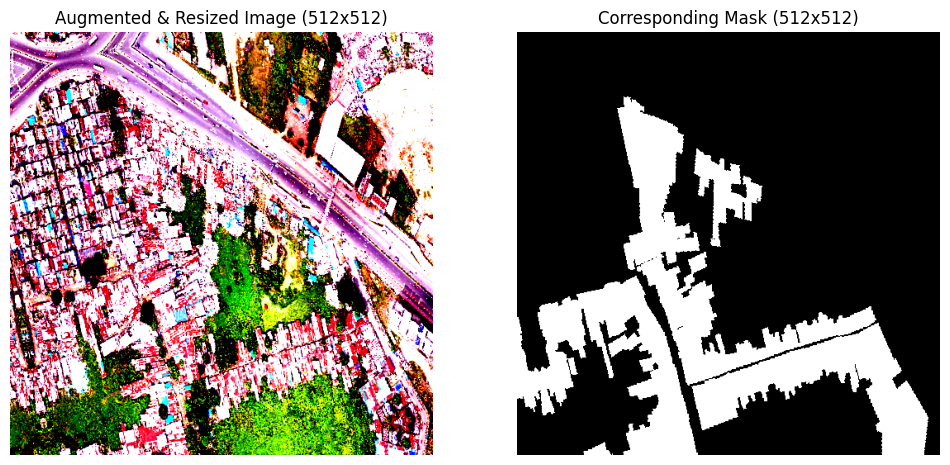

In [ ]:
sample_image, sample_mask = full_dataset[0]
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(np.transpose(sample_image.cpu().numpy(), (1, 2, 0)))
plt.title("Augmented & Resized Image (512x512)")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(sample_mask.squeeze(), cmap='gray')
plt.title("Corresponding Mask (512x512)")
plt.axis('off')
plt.show()


In [ ]:

#evaluation Metrics
def dice_coef(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def jaccard_index(pred, target, smooth=1.):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return jaccard.mean()

def pixel_accuracy(pred, target):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    correct = (pred == target).float()
    return correct.sum() / correct.numel()

In [ ]:
#UNet with ResNet50 Encoder
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1, # binary seg output
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Loss, Optimizer
#criterion = nn.BCEWithLogitsLoss()

#Hybrid Loss: Dice + Focal
dice_loss = smp.losses.DiceLoss(mode='binary')
focal_loss = smp.losses.FocalLoss(mode='binary')

def hybrid_loss(y_pred, y_true):
    return 0.5 * dice_loss(y_pred, y_true) + 0.5 * focal_loss(y_pred, y_true)

criterion = hybrid_loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 354MB/s]


In [ ]:
import os
import time
import torch

checkpoint_dir = '/kaggle/working/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
num_epochs = 100
total_training_time = 0.0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_dices = []
val_dices = []
train_jaccards = []
val_jaccards = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    model.train()
    train_loss = 0.0
    train_dice = 0.0
    train_jaccard = 0.0
    train_acc = 0.0
    n_train_batches = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device) #shape= [B, 1, 512, 512] with values in [0,1]

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_dice += dice_coef(outputs, masks).item()
        train_jaccard += jaccard_index(outputs, masks).item()
        train_acc += pixel_accuracy(outputs, masks).item()
        n_train_batches += 1

    train_loss /= n_train_batches
    train_dice /= n_train_batches
    train_jaccard /= n_train_batches
    train_acc /= n_train_batches

    model.eval() #Val
    val_loss = 0.0
    val_dice = 0.0
    val_jaccard = 0.0
    val_acc = 0.0
    n_val_batches = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_dice += dice_coef(outputs, masks).item()
            val_jaccard += jaccard_index(outputs, masks).item()
            val_acc += pixel_accuracy(outputs, masks).item()
            n_val_batches += 1

    val_loss /= n_val_batches
    val_dice /= n_val_batches
    val_jaccard /= n_val_batches
    val_acc /= n_val_batches

    epoch_time = time.time() - epoch_start_time
    total_training_time += epoch_time

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_dices.append(train_dice)
    val_dices.append(val_dice)
    train_jaccards.append(train_jaccard)
    val_jaccards.append(val_jaccard)


    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Dice: {train_dice:.4f}, Train Jaccard: {train_jaccard:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Dice: {val_dice:.4f}, Val Jaccard: {val_jaccard:.4f} | "
          f"Time: {epoch_time:.2f}s")

checkpoint_path = os.path.join(checkpoint_dir, 'Unet_ResNet50.pth') #save model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
    'train_dice': train_dice,
    'val_dice': val_dice,
    'train_jaccard': train_jaccard,
    'val_jaccard': val_jaccard,
    'train_acc': train_acc,
    'val_acc': val_acc
}, checkpoint_path)

print(f"Final model checkpoint saved at {checkpoint_path}")
print(f"Total Training Time: {total_training_time:.2f}s")


Epoch [1/100] - Train Loss: 0.5059, Train Acc: 0.4414, Train Dice: 0.1701, Train Jaccard: 0.0951 | Val Loss: 0.4270, Val Acc: 0.3023, Val Dice: 0.2572, Val Jaccard: 0.1504 | Time: 17.84s
Epoch [2/100] - Train Loss: 0.4454, Train Acc: 0.5742, Train Dice: 0.2309, Train Jaccard: 0.1368 | Val Loss: 0.4107, Val Acc: 0.3506, Val Dice: 0.2544, Val Jaccard: 0.1484 | Time: 17.50s
Epoch [3/100] - Train Loss: 0.4163, Train Acc: 0.6716, Train Dice: 0.3112, Train Jaccard: 0.1928 | Val Loss: 0.4127, Val Acc: 0.3229, Val Dice: 0.2834, Val Jaccard: 0.1681 | Time: 16.95s
Epoch [4/100] - Train Loss: 0.3907, Train Acc: 0.7371, Train Dice: 0.4040, Train Jaccard: 0.2670 | Val Loss: 0.3993, Val Acc: 0.3595, Val Dice: 0.3014, Val Jaccard: 0.1805 | Time: 16.55s
Epoch [5/100] - Train Loss: 0.3689, Train Acc: 0.7539, Train Dice: 0.4362, Train Jaccard: 0.2957 | Val Loss: 0.3835, Val Acc: 0.4011, Val Dice: 0.3295, Val Jaccard: 0.2007 | Time: 16.40s
Epoch [6/100] - Train Loss: 0.3566, Train Acc: 0.7509, Train Dice

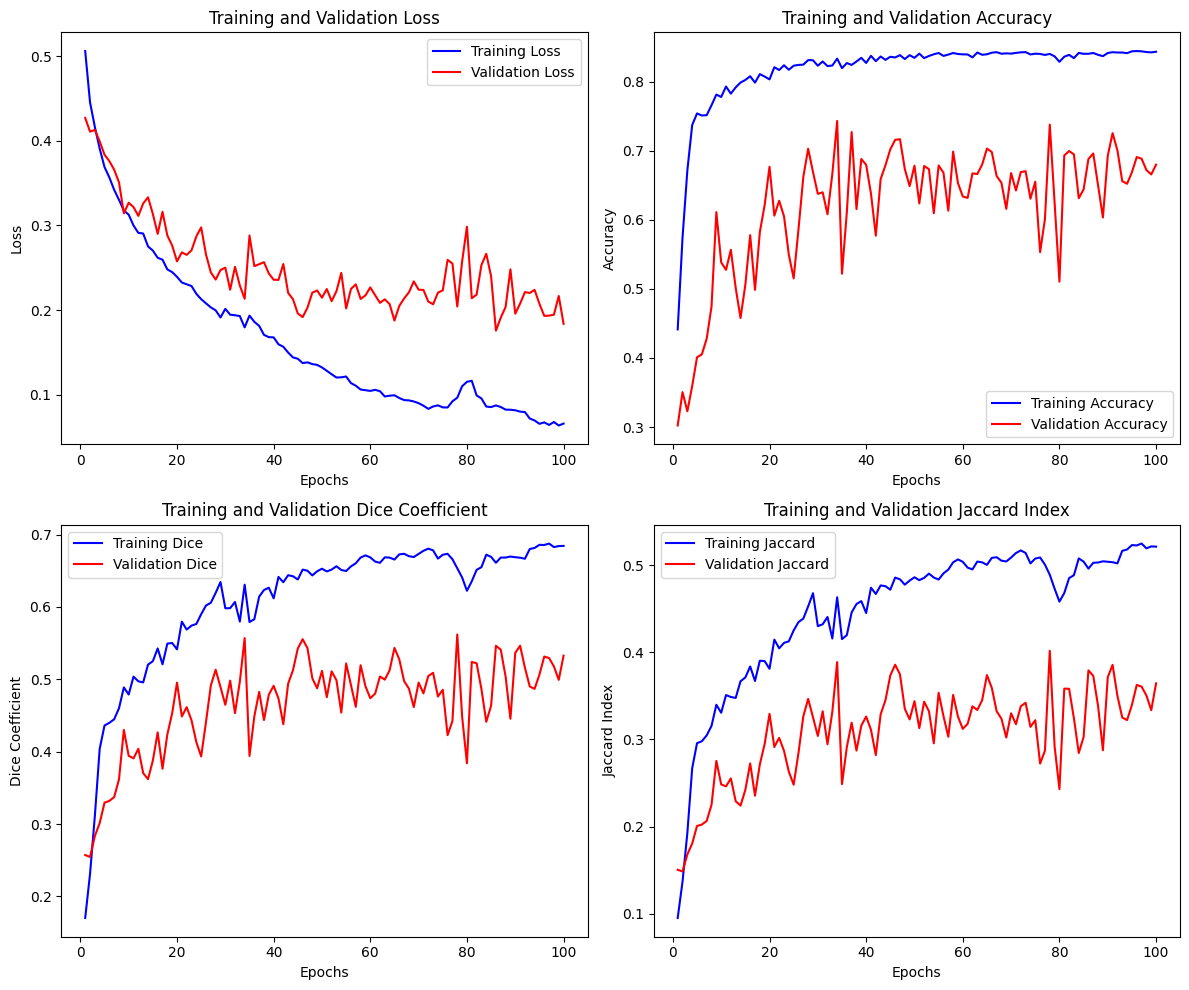

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 10))
#loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#dice coefficient
plt.subplot(2, 2, 3)
plt.plot(epochs, train_dices, 'b', label='Training Dice')
plt.plot(epochs, val_dices, 'r', label='Validation Dice')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

#jaccard index
plt.subplot(2, 2, 4)
plt.plot(epochs, train_jaccards, 'b', label='Training Jaccard')
plt.plot(epochs, val_jaccards, 'r', label='Validation Jaccard')
plt.title('Training and Validation Jaccard Index')
plt.xlabel('Epochs')
plt.ylabel('Jaccard Index')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Test
model.eval()
test_loss = 0.0
test_acc = 0.0
test_dice = 0.0
test_jaccard = 0.0
n_test_batches = 0

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        test_loss += loss.item()
        test_dice += dice_coef(outputs, masks).item()
        test_jaccard += jaccard_index(outputs, masks).item()
        test_acc += pixel_accuracy(outputs, masks).item()
        n_test_batches += 1

test_loss /= n_test_batches
test_dice /= n_test_batches
test_jaccard /= n_test_batches
test_acc /= n_test_batches

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Dice: {test_dice:.4f}")
print(f"Test Jaccard: {test_jaccard:.4f}")


Test Loss: 0.1596
Test Accuracy: 0.8774
Test Dice: 0.5460
Test Jaccard: 0.3784


In [ ]:
pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.2 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39680 sha256=a2760759bab3460c8b7296cd9ce609db3c13df3d3db0851d1a40ad6142bc7ad0
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam
Note: you may need to restart the kernel to use updated packages.


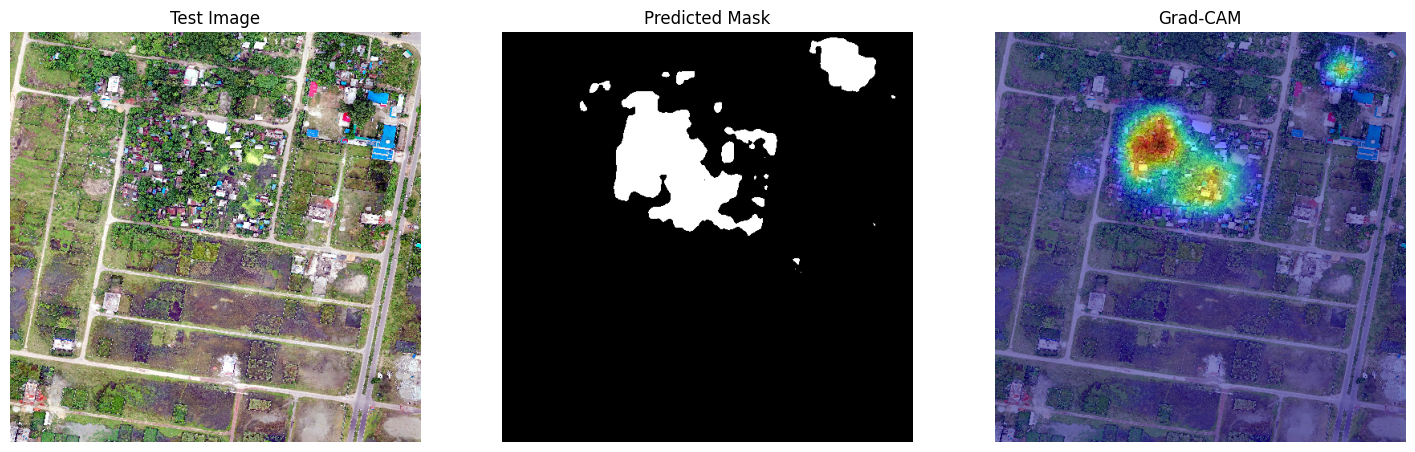

In [ ]:
#gradCAM Analysis on Test
#1st sample
#pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

test_iter = iter(test_loader)
test_images, test_masks = next(test_iter)

input_image_test = test_images[0:1].to(device)

#denormalize the test img for visualization
#(Normalization was applied using mean=[0.485, 0.456, 0.406] , std=[0.229, 0.224, 0.225])
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
denorm_img = input_image_test[0].cpu().clone()
for t, m, s in zip(denorm_img, mean, std):
    t.mul_(s).add_(m)
denorm_img_np = denorm_img.clamp(0, 1).permute(1, 2, 0).numpy()  # shape: H, W, C


target_layer = model.encoder.layer4[-1] #targeted layer

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
cam = GradCAM(model=model, target_layers=[target_layer])

targets = [lambda output: output.mean()]

grayscale_cam = cam(input_tensor=input_image_test, targets=targets)[0]


visualization = show_cam_on_image(denorm_img_np.astype(np.float32),
                                  grayscale_cam,
                                  use_rgb=True)

model.eval()
with torch.no_grad():
    output_test = model(input_image_test)
    pred_mask_test = torch.sigmoid(output_test)
    pred_mask_test = (pred_mask_test > 0.5).float().cpu().squeeze()

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(denorm_img_np)
axes[0].set_title("Test Image")
axes[0].axis("off")

axes[1].imshow(pred_mask_test, cmap="gray")
axes[1].set_title("Predicted Mask")
axes[1].axis("off")

axes[2].imshow(visualization)
axes[2].set_title("Grad-CAM")
axes[2].axis("off")

plt.show()


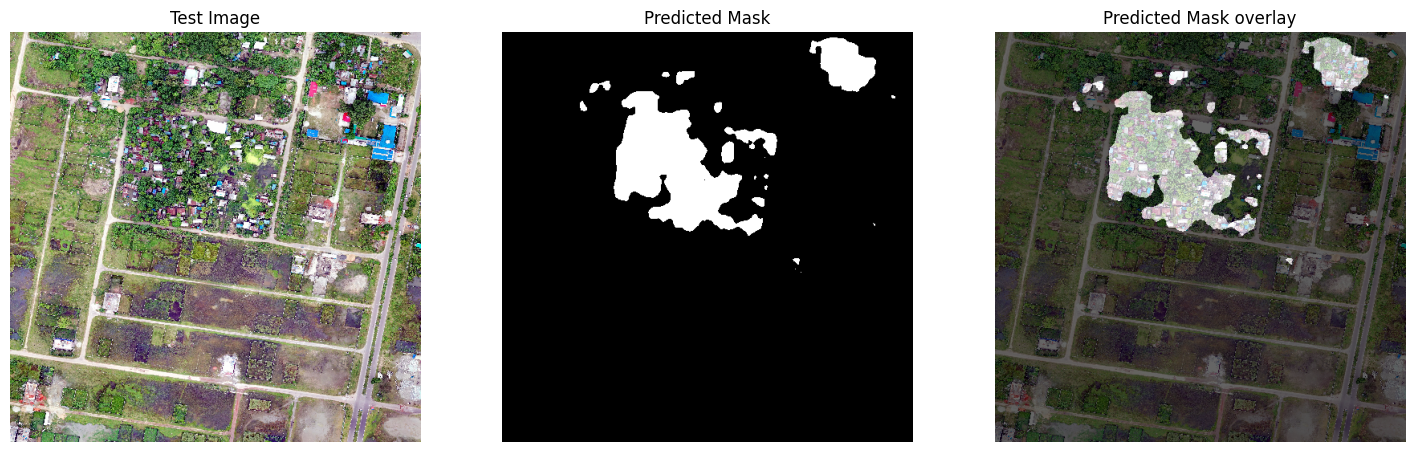

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
#1st sample
test_iter = iter(test_loader)
test_images, test_masks = next(test_iter)

input_image_test = test_images[0:1].to(device)

#Denormalize
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
denorm_img = input_image_test[0].cpu().clone()
for t, m, s in zip(denorm_img, mean, std):
    t.mul_(s).add_(m)
denorm_img_np = denorm_img.clamp(0, 1).permute(1, 2, 0).numpy()

model.eval() #Make predictions on test image
with torch.no_grad():
    output_test = model(input_image_test)
    pred_mask_test = torch.sigmoid(output_test)
    pred_mask_test = (pred_mask_test > 0.5).float().cpu().squeeze()

pred_mask_np = pred_mask_test.numpy()

heatmap = np.zeros_like(denorm_img_np)
heatmap[:, :, 0] = pred_mask_np
heatmap[:, :, 1] = pred_mask_np
heatmap[:, :, 2] = pred_mask_np

overlay = 0.6 * heatmap + 0.4 * denorm_img_np  # 60% heatmap, 40% image , alpha blending

#Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(denorm_img_np)
axes[0].set_title("Test Image")
axes[0].axis("off")

axes[1].imshow(pred_mask_test, cmap="gray")
axes[1].set_title("Predicted Mask")
axes[1].axis("off")

axes[2].imshow(overlay)
axes[2].set_title("Predicted Mask overlay")
axes[2].axis("off")

plt.show()


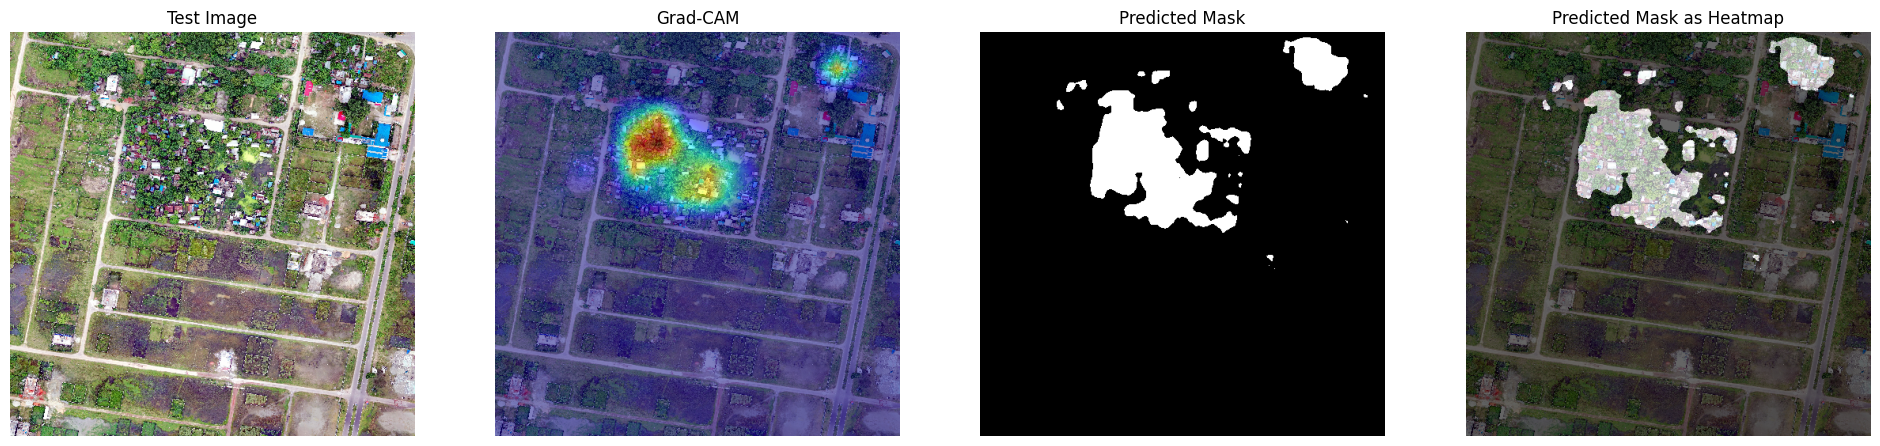

In [ ]:
input_image_test = test_images[0:1].to(device)

#Denormalize
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
denorm_img = input_image_test[0].cpu().clone()
for t, m, s in zip(denorm_img, mean, std):
    t.mul_(s).add_(m)
denorm_img_np = denorm_img.clamp(0, 1).permute(1, 2, 0).numpy()

#Grad-CAM analysis
target_layer = model.encoder.layer4[-1]
cam = GradCAM(model=model, target_layers=[target_layer])

targets = [lambda output: output.mean()]
grayscale_cam = cam(input_tensor=input_image_test, targets=targets)[0]
visualization = show_cam_on_image(denorm_img_np.astype(np.float32),
                                  grayscale_cam,
                                  use_rgb=True)

pred_mask_test = (pred_mask_test > 0.5).float().cpu().squeeze()
pred_mask_np = pred_mask_test.numpy()

heatmap = np.zeros_like(denorm_img_np)
heatmap[:, :, 0] = pred_mask_np
heatmap[:, :, 1] = pred_mask_np
heatmap[:, :, 2] = pred_mask_np

overlay = 0.6 * heatmap + 0.4 * denorm_img_np # 60% heatmap 40% image

# Plot
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

axes[0].imshow(denorm_img_np)
axes[0].set_title("Test Image")
axes[0].axis("off")

axes[1].imshow(visualization)
axes[1].set_title("Grad-CAM")
axes[1].axis("off")

axes[2].imshow(pred_mask_test, cmap="gray")
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

axes[3].imshow(overlay)
axes[3].set_title("Predicted Mask as Heatmap")
axes[3].axis("off")

plt.show()
